# Set-up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/image_classification'

/content/drive/MyDrive/image_classification


In [ ]:
import os 
import gc 
import copy 

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 

import easydict 
from tqdm import notebook

# image 
from PIL import Image

# visualization
import matplotlib.pyplot as plt
import seaborn as sns  

# pytorch 
import torch 
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader 

import torch.nn as nn 
import torch.nn.functional as F 
from torch.optim import Adam, AdamW 

from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision import transforms 

In [ ]:
!pip install timm 
import timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
config = {}

# setting 
config['seed'] = 42 
config['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

# data 
config['num_workers'] = 1 
config['pin_memory'] = True 

# model 
config['hidden_dim'] = 128
config['dropout'] = 0.1

# training
config['n_epochs'] = 20
config['batch_size'] = 64
config['lr'] = 0.0001
config['clip_grad'] = 10
config['log_steps'] = 50
config['patience'] = 5

args = easydict.EasyDict(config)

# 데이터 

## data lookup table

In [ ]:
data_path = '/content/drive/MyDrive/image_classification'

In [ ]:
# from zipfile import ZipFile

# with ZipFile(data_path + '/train.zip') as zipper : 
#   zipper.extractall()

# with ZipFile(data_path + '/test.zip') as zipper : 
#   zipper.extractall()

In [ ]:
# path 
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')

In [ ]:
label2idx = {'dog' : 0,
             'elephant' : 1, 
             'giraffe' : 2,
             'guitar' : 3,
             'horse' : 4,
             'house' : 5,
             'person' : 6}

idx2label = {v: k for k, v in label2idx.items()}


In [ ]:
labels = [] 

for path in os.walk(train_path) : 
  label_type = path[0].split('/')[-1]
  if label_type == 'train' :
      continue

  base_path = path[0] # image directory
  images = path[2] # file names 

  idx = label2idx[label_type]
  for image in images : 
    img_path = os.path.join(base_path, image)
    label = {'img_path' : img_path, 
             'label' : idx}

    labels.append(label)

train_df = pd.DataFrame(labels)
train_df = train_df.sort_values(['label', 'img_path'])
train_df.reset_index(drop = True, inplace = True)
train_df.head()

,img_path,label
0,/content/drive/MyDrive/image_classification/tr...,0
1,/content/drive/MyDrive/image_classification/tr...,0
2,/content/drive/MyDrive/image_classification/tr...,0
3,/content/drive/MyDrive/image_classification/tr...,0
4,/content/drive/MyDrive/image_classification/tr...,0


In [ ]:
labels = [] 

for path in os.walk(test_path) : 
  base_path = path[0] # image directory
  images = path[2] # file names 

  for image in images : 
    img_path = os.path.join(base_path, image)
    label = {'img_path' : img_path, 
             'label' : -1}

    labels.append(label)

test_df = pd.DataFrame(labels)
test_df = test_df.sort_values(['img_path'])
test_df.reset_index(drop = True, inplace = True)
test_df.head()

,img_path,label
0,/content/drive/MyDrive/image_classification/te...,-1
1,/content/drive/MyDrive/image_classification/te...,-1
2,/content/drive/MyDrive/image_classification/te...,-1
3,/content/drive/MyDrive/image_classification/te...,-1
4,/content/drive/MyDrive/image_classification/te...,-1


# EDA 
- 실제 사진이 아니라 미술 작품임(실제 사진과 어떻게 다른 특성을 가지는가?)
- 각 label 별로 누락된 이미지들이 있다.
  - ? 

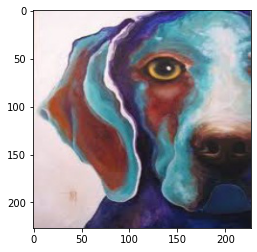

In [ ]:
image = plt.imread(train_df['img_path'][0])
plt.imshow(image)

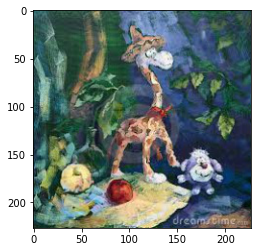

In [ ]:
image = plt.imread(test_df['img_path'][0])
plt.imshow(image)

In [ ]:
list(label2idx.keys())

['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

[Text(0, 0, 'dog'),
 Text(0, 0, 'elephant'),
 Text(0, 0, 'giraffe'),
 Text(0, 0, 'guitar'),
 Text(0, 0, 'horse'),
 Text(0, 0, 'house'),
 Text(0, 0, 'person')]

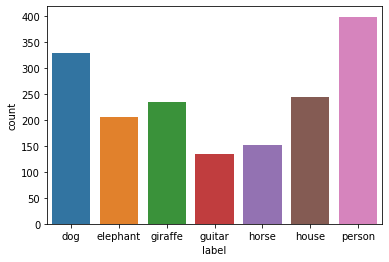

In [ ]:
p = sns.countplot(train_df['label'])
p.set_xticklabels(list(label2idx.keys()))

In [ ]:
train_df['label']

0       0
1       0
2       0
3       0
4       0
       ..
1693    6
1694    6
1695    6
1696    6
1697    6
Name: label, Length: 1698, dtype: int64

In [ ]:
test_df.count()

img_path    350
label       350
dtype: int64

# Dataset & DataLoader

In [ ]:
class ArtDataset(Dataset) : 
  def __init__(self, df, transform = None) : 
    self.df = df 
    self.transform = transform 

  def __getitem__(self, idx) :
    data = self.df.iloc[idx]

    # image 
    img_path = data['img_path']
    image = Image.open(img_path)

    if self.transform : 
      image = self.transform(image)

    # label 
    label = data['label']

    return image, label

  def __len__(self) : 
    return len(self.df)

In [ ]:
transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([.485, .456, .406],
                                                     [.229, .224, .225])])

dataset = ArtDataset(train_df, transform)
dataset[7]

(tensor([[[ 1.6495,  1.6838,  1.7009,  ...,  0.8276,  0.6734,  0.7419],
          [ 1.6838,  1.7865,  1.8722,  ...,  0.8276,  0.6563,  0.6563],
          [ 1.6838,  1.9235,  2.0605,  ...,  0.9474,  0.6563,  0.6049],
          ...,
          [-1.3644, -1.6042, -1.6555,  ..., -1.6213, -1.6727, -1.7069],
          [-1.2959, -1.5699, -1.7754,  ..., -1.7925, -1.8782, -1.8268],
          [-1.4158, -1.7069, -1.7583,  ..., -1.9980, -2.0152, -1.9809]],
 
         [[ 1.7458,  1.7983,  1.8508,  ...,  0.2227,  0.2227,  0.3102],
          [ 1.7808,  1.8859,  2.0259,  ...,  0.0826,  0.0651,  0.0651],
          [ 1.7633,  2.0259,  2.2185,  ...,  0.1527, -0.0399, -0.1099],
          ...,
          [-1.4580, -1.7031, -1.7731,  ..., -1.6856, -1.6155, -1.6506],
          [-1.3704, -1.6681, -1.8782,  ..., -1.8256, -1.8081, -1.7556],
          [-1.4930, -1.8081, -1.8606,  ..., -2.0357, -1.9482, -1.9132]],
 
         [[ 1.4548,  1.4722,  1.5245,  ..., -1.3861, -1.2467, -1.1247],
          [ 1.5245,  1.5942,

In [ ]:
loader = DataLoader(dataset, shuffle = True, batch_size = 32)

for x, y in loader : 
  print(x, y) 
  break

tensor([[[[ 0.0741,  0.9474,  0.2282,  ..., -1.3644, -1.2103, -1.2274],
          [ 0.0569,  1.2557,  0.8789,  ..., -1.3644, -1.2617, -1.2788],
          [-0.3369,  0.0912, -0.0972,  ..., -1.3473, -1.2103, -1.2445],
          ...,
          [-1.7925, -1.4843, -1.4329,  ..., -0.8335, -0.7479, -0.8849],
          [-1.6555, -1.5185, -1.4843,  ..., -0.7308, -0.6794, -0.6109],
          [-1.6555, -1.5870, -1.4500,  ..., -0.8335, -0.5424, -0.2856]],

         [[-0.2150,  0.6604, -0.0749,  ..., -1.6331, -1.5280, -1.5455],
          [-0.1800,  1.0455,  0.6604,  ..., -1.7031, -1.5980, -1.6155],
          [-0.5126, -0.0749, -0.2675,  ..., -1.7381, -1.5980, -1.6331],
          ...,
          [-1.7906, -1.4755, -1.4055,  ..., -0.8102, -0.8452, -1.0378],
          [-1.6681, -1.5805, -1.5455,  ..., -0.9328, -0.9328, -0.8277],
          [-1.6681, -1.6506, -1.5105,  ..., -1.0378, -0.7577, -0.4776]],

         [[-0.5844,  0.3393, -0.3927,  ..., -1.4907, -1.3687, -1.3861],
          [-0.4973,  0.7228,  

# Train / Valid split 

In [ ]:
from sklearn.model_selection import StratifiedKFold 

def split_df(df, kfold_n = 5) : 
  kfold = StratifiedKFold(n_splits = kfold_n)

  X = df.img_path.values
  y = df.label.values

  datas = [] 
  for i, (train_index, valid_index) in enumerate(kfold.split(X, y)) : 
    train_df = df.iloc[train_index].copy().reset_index(drop = True)
    valid_df = df.iloc[valid_index].copy().reset_index(drop = True)

    datas.append((train_df, valid_df))

  return datas

In [ ]:
datas = split_df(train_df)

In [ ]:
# fold 1, train 
datas[0][0]['label'].value_counts().sort_index()

0    263
1    164
2    188
3    107
4    121
5    196
6    319
Name: label, dtype: int64

In [ ]:
# fold 1, valid
datas[0][1]['label'].value_counts().sort_index()

0    66
1    41
2    47
3    27
4    30
5    49
6    80
Name: label, dtype: int64

# get_loader

In [ ]:
def get_loader(train_data, valid_data, transform) : 
  train_dataset = ArtDataset(train_data, transform)
  valid_dataset = ArtDataset(valid_data, transform)

  train_loader = DataLoader(train_dataset, 
                            shuffle = True, 
                            num_workers = args.num_workers,
                            batch_size = args.batch_size,
                            pin_memory = args.pin_memory)
  valid_loader = DataLoader(valid_dataset, 
                            shuffle = True, 
                            num_workers = args.num_workers,
                            batch_size = args.batch_size,
                            pin_memory = args.pin_memory)
  
  return train_loader, valid_loader

# Model

In [ ]:
for X, y in loader : 
  print(X.size(), y.size())
  break

torch.Size([32, 3, 224, 224]) torch.Size([32])


## conv model 
- 간단한 convolution model을 사용해서 test

In [ ]:
class ConvNet(nn.Module) : 
  def __init__(self, args, class_n = 7) : 
    super().__init__()

    self.model = nn.Sequential(
        # 32, 3, 224, 224 -> 32, 32, 55, 55
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 8, stride = 4),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        # 32, 32, 55, 55 -> 32, 32, 27, 27
        nn.MaxPool2d((2, 2)),

        # 32, 32, 27, 27 -> 32, 64, 11, 11
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 7, stride = 2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        # 32, 64, 11, 11 -> 32, 64, 5, 5
        nn.MaxPool2d((2, 2)),
    )
    self.fc = nn.Linear(64 * 5 * 5, class_n)

  def forward(self, x) :
    x = self.model(x)
    x = x.view(-1, 64 * 5 * 5)
    x = self.fc(x)
    return x

In [ ]:
model = ConvNet(args)
model(X)

tensor([[ 1.0879e+00,  1.0266e+00, -1.0703e+00,  8.0077e-01,  1.1093e+00,
         -6.0304e-01, -6.7924e-01],
        [ 2.5399e-01,  6.5339e-01, -3.9554e-01,  3.2249e-01,  4.3371e-01,
         -5.8898e-01, -2.2816e-02],
        [ 2.9769e-01,  5.9819e-01, -6.3202e-01,  2.1083e-01,  5.8368e-01,
         -1.0964e-01, -2.1765e-01],
        [ 2.0285e-01,  1.5710e-01, -3.5891e-01,  5.6165e-01,  1.0156e+00,
         -2.7812e-01, -5.8168e-04],
        [-1.8845e-01,  1.1983e+00, -4.2058e-01,  2.9053e-01,  6.0229e-01,
         -7.1465e-01,  5.2313e-01],
        [-1.6779e-01,  3.1255e-01, -3.6183e-01,  8.2943e-01,  7.4569e-01,
         -6.9695e-01,  1.6120e-01],
        [ 5.8063e-01,  8.9031e-01, -7.5850e-01,  1.1969e-01,  2.6514e-01,
         -4.4535e-01,  9.6925e-02],
        [ 5.2976e-01,  1.7255e+00, -3.3514e-01,  1.0203e+00,  5.1655e-01,
         -4.9031e-01, -2.1699e-01],
        [ 5.3371e-02,  5.9708e-01, -4.0063e-01,  5.3198e-01,  6.6139e-01,
         -2.9704e-01, -6.7312e-01],
        [ 

## EfficientNet 1

In [ ]:
class Eff01(nn.Module) : 
  def __init__(self, args, class_n = 7) : 
    super().__init__()
    self.model = timm.create_model('efficientnet_b1', 
                                   pretrained = True,
                                   num_classes = class_n)
    
  def forward(self, x) : 
    x = self.model(x) 
    return x 

In [ ]:
model = Eff01(args) 
model(X)

tensor([[ 4.4633,  2.6525,  5.0606, -2.7541, -1.5827,  2.5264, -0.1804],
        [ 2.0744, -1.5416,  1.0576, -0.9088,  0.5181,  1.3586, -0.4483],
        [ 5.8515,  6.8697, -1.9061, -2.3410,  0.1849, -2.0959, -2.5918],
        [ 1.6347, -2.3995,  4.7612,  2.7883, -0.8863, -3.9384, -3.7595],
        [ 0.1020,  0.4941,  3.4540,  5.1449, -2.8838,  1.3132,  1.6924],
        [ 6.0206,  0.2906,  3.5553, -0.6662,  2.2883, -0.0607, -1.0596],
        [ 1.9874, -6.4545,  5.8725,  1.6803, -2.7604,  0.8502,  2.0693],
        [ 0.9728,  2.1616,  1.4261,  5.3135,  0.6342, -1.2457,  0.7519],
        [ 0.4766, -0.4565,  0.4652,  3.5876, -1.3585, -4.1233, -2.1248],
        [ 5.0708,  4.8757, -5.7431, -0.5191,  2.0419, -2.7857, -1.8193],
        [ 4.6492,  4.3091, -1.5544,  2.1299,  3.8314, -4.4879,  1.2716],
        [-1.2719,  2.2674,  1.8018,  7.6858, -0.7240, -3.6726, -3.4695],
        [ 6.0813, -6.1485,  0.5922,  0.4175, -0.8164,  0.8486, -4.6227],
        [-1.7283,  1.7549, -2.1245,  0.3571, -0.404

## EfficientNet 3

In [ ]:
class Eff03(nn.Module) : 
  def __init__(self, args, class_n = 7) : 
    super().__init__()
    self.model = timm.create_model('efficientnet_b3', 
                                   pretrained = True,
                                   num_classes = class_n)
    
  def forward(self, x) : 
    x = self.model(x) 
    return x 

In [ ]:
model = Eff03(args) 
model(X)

tensor([[-5.7033, -0.7044, -0.4256, -0.0900, -3.7883, -1.9896, -0.7801],
        [-1.5093,  2.2185,  4.1762, -0.0853, -2.0295,  1.5152,  4.2802],
        [ 1.4758, -2.2976, -1.4935, -5.0694, -2.6654, -0.3370,  4.2300],
        [-2.3005, -4.1297,  5.3572, -0.6139, -3.0781, -5.2998, -1.1040],
        [-2.8665, -0.7836, -0.6695, -2.8624,  1.2261,  5.5449, -2.5484],
        [ 0.4901,  2.4865, -2.4029, -1.8184, -2.0347, -4.6670, -0.1960],
        [ 2.2796, -1.0621,  3.6204,  3.1323, -0.3051,  2.5300,  1.7215],
        [ 1.2411,  0.7549, -2.2347,  1.6263, -1.0163,  1.6832, -2.3699],
        [-0.8864, -0.9239, -0.8539, -0.1506,  0.7033,  4.1372, -1.0628],
        [-0.6959, -1.7785, -2.2974, -3.7414, -4.1174, -0.3033, -0.3725],
        [-6.4099,  1.2390,  3.7260,  0.1479, -2.9473, -2.4895,  1.1912],
        [-5.0331,  2.9273, -0.8020, -1.3027, -4.3305,  4.2747,  3.7730],
        [ 1.8739, -1.4675, -1.2522, -3.5986, -4.7757,  1.1597, -1.9649],
        [-1.3941,  2.2602, -0.4062, -1.8055, -1.554

## timm

In [ ]:
class Timm(nn.Module) : 
  def __init__(self, args, class_n = 7) : 
    super().__init__()
    self.model = timm.create_model(args.timm_model,
                                   pretrained = True,
                                   num_classes = class_n)
    
  def forward(self, x) : 
    x = self.model(x) 
    return x 

# Training

## initial settings 

In [ ]:
config = {}

# setting 
config['seed'] = 42 
config['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
config['model_path'] = os.path.join(data_path, 'model')

# data 
config['num_workers'] = 1 
config['pin_memory'] = False

# model 
config['dropout'] = 0.1

# training
config['n_epochs'] = 20
config['batch_size'] = 32
config['lr'] = 0.0001
config['clip_grad'] = 10
config['log_steps'] = 1
config['patience'] = 10

config['model'] = 'timm'
config['timm_model'] = 'vit_small_patch16_224'

config['optimizer'] = 'adam'
config['scheduler'] = 'plateau'

config['load'] = False
config['model_name'] = ''

config['kfold'] = 1 

config['pseudo_labeling'] = False
config['pseudo_iter_n'] = 2

args = easydict.EasyDict(config)

## criterion

In [ ]:
criterion = nn.CrossEntropyLoss()

## get_model

In [ ]:
def get_model(args) : 
  """
  load model and move tensors to device
  """

  if args.model == 'convnet' : 
    model = ConvNet(args)

  if args.model == 'eff1' : 
    model = Eff01(args)

  if args.model == 'eff3' : 
    model = Eff03(args)

  if args.model == 'timm' : 
    model = Timm(args)

  model.to(args.device)

  return model

## get_optimizer 

In [ ]:
def get_optimizer(model, args) : 
  if args.optimizer == 'adam' : 
    optimizer = Adam(model.parameters(),
                     lr = args.lr,
                     weight_decay = 0.0)
    
  optimizer.zero_grad()

  return optimizer 

## get_scheduler

In [ ]:
def get_scheduler(optimizer, args) : 
  if args.scheduler == 'plateau' : 
    scheduler = ReduceLROnPlateau(optimizer, 
                                 patience = 3, 
                                 factor = 0.5, 
                                 mode = 'max', 
                                 verbose = True)
    
  return scheduler

## train

In [ ]:
def train(args, model, train_loader, optimizer) : 
  model.train() 

  corrects = 0 

  for step, (images, labels) in enumerate(train_loader) : 
    images = images.to(args.device)
    labels = labels.to(args.device)

    outputs = model(images) 
    if args.timm_model == 'vit_base_patch16_224' : 
      outputs = outputs[0]

    loss = criterion(outputs, labels) 
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    if step % args.log_steps == 0 : 
      print(f'Training steps : {step} / Loss : {str(loss.item())}')

    _, preds = torch.max(outputs, 1)

    corrects += torch.sum(preds == labels.data)

  acc = corrects / args.train_len
  return acc

## validate 

In [ ]:
def validate(args, model, valid_loader) : 
  model.eval() 

  corrects = 0 

  for images, labels in valid_loader : 
    images = images.to(args.device)
    labels = labels.to(args.device)

    outputs = model(images) 

    _, preds = torch.max(outputs, 1)

    corrects += torch.sum(preds == labels.data)

  acc = corrects / args.valid_len
  print(f' Valid ACC : {acc}\n')

  return acc, outputs

## pseudo_labeling 

In [ ]:
def pseudo_labeling(args, model, train_data) : 
  # train_data에 새로운 df 
  new_train_data = copy.deepcopy(test_df)

  test_dataset = ArtDataset(test_df, transform) 
  test_loader = DataLoader(test_dataset, 
                           shuffle = False, 
                           num_workers = args.num_workers, 
                           batch_size = args.batch_size,
                           pin_memory = args.pin_memory)
  
  model.eval()
  answers = [] 

  for images, labels in test_loader : 
    images = images.to(args.device)
    labels = labels.to(args.device)

    outputs = model(images)

    _, preds = torch.max(outputs, 1)

    answers.extend(list(preds.cpu().numpy()))

  new_train_data.label = answers 
  new_train_data = pd.concat([train_data, new_train_data]).reset_index(drop = True)

  return new_train_data

## run 

In [ ]:
def run(args, train_data, valid_data) : 
  """
  데이터셋을 제공하면 모든 훈련 사이클을 실행
  """

  # 캐시 메모리 비우기 및 가비지 컬렉터 가동
  torch.cuda.empty_cache()
  gc.collect()

  # load data 
  args.train_len = len(train_data)
  args.valid_len = len(valid_data)
  transform = transforms.Compose([transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize([.485, .456, .406],
                                                       [.229, .224, .225])])
  train_loader, valid_loader = get_loader(train_data, valid_data, transform)

  if args.load : 
    model = torch.load(os.path.join(args.model_path, args.model_name))

  else : 
    model = get_model(args)

  optimizer = get_optimizer(model, args)
  scheduler = get_scheduler(optimizer, args)

  early_stopping_counter = 0 
  best_acc = -1

  if args.pseudo_labeling : 
    iter_n = args.pseudo_iter_n

  else : 
    iter_n = 1 

  # pseudo_labeling 을 위한 iteration 
  for iter_i in range(iter_n) : 
    for epoch in notebook.tqdm(range(args.n_epochs)) : 
      print(f'Epoch {epoch + 1} / {args.n_epochs}')

      # train 
      train_acc = train(args, model, train_loader, optimizer)

      # valid 
      valid_acc, outputs = validate(args, model, valid_loader)

      # model save and early stopping 
      if valid_acc > best_acc : 
        best_acc = valid_acc 
        early_stopping_counter = 0 

        # model save 
        if args.model == 'timm' : 
          save_name = f'{args.timm_model}_fold{args.kfold}_{str(best_acc.item())[:4]}'

        else : 
          save_name = f'{args.model}_fold{args.kfold}_{str(best_acc.item())[:4]}'

        torch.save(model, os.path.join(args.model_path, save_name))
        print(f'model saved as {save_name}')

      else :
        early_stopping_counter += 1 
        if early_stopping_counter > args.patience : 
          print(f'EarlyStopping counter : {early_stopping_counter} out of {args.patience}')
          break

      # scheduler
      if args.scheduler == 'plateau' : 
        scheduler.step(best_acc)

    # Pseudo labeling 
    if args.pseudo_labeling : 
      print('pseudo labeling ongoing')
      train_data = pseudo_labeling(args, model, train_data)

      # make a loader with new train data 
      train_loader, _ = get_loader(train_data, valid_data, transform)

    

In [ ]:
datas = split_df(train_df)

# 하나의 fold만 사용 
train_data = datas[args.kfold -1][0]
valid_data = datas[args.kfold -1][1]

In [ ]:
args.lr = 0.0001
args.load = False 
args.model_name = ''

args.batch_size = 16
args.log_steps = 20

args.patience = 5

In [ ]:
timm.list_models(pretrained = True)[:10]

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'botnet26t_256']

In [ ]:
args.timm_model = 'deit3_base_patch16_224'
kfold_n = 5 
for fold in range(1, kfold_n + 1) : 
  args.kfold = fold

  train_data = datas[args.kfold - 1][0]
  test_data = datas[args.kfold - 1][1]
  run(args, train_data, valid_data)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 / Loss : 2.036166191101074
Training steps : 20 / Loss : 0.6212823390960693
Training steps : 40 / Loss : 0.1721624732017517
Training steps : 60 / Loss : 0.24830378592014313
Training steps : 80 / Loss : 0.12837782502174377
 Valid ACC : 0.9882352948188782

model saved as deit3_base_patch16_224_fold1_0.98
Epoch 2 / 20
Training steps : 0 / Loss : 0.021795015782117844
Training steps : 20 / Loss : 0.0028046644292771816
Training steps : 40 / Loss : 0.0011752487625926733
Training steps : 60 / Loss : 0.1987617015838623
Training steps : 80 / Loss : 0.001894250512123108
 Valid ACC : 0.9764705896377563

Epoch 3 / 20
Training steps : 0 / Loss : 0.015239437110722065
Training steps : 20 / Loss : 0.014393887482583523
Training steps : 40 / Loss : 0.06813717633485794
Training steps : 60 / Loss : 0.005717471707612276
Training steps : 80 / Loss : 0.003118230262771249
 Valid ACC : 0.9764705896377563

Epoch 4 / 20
Training steps : 0 / Loss : 0.00047990019083954394
Training ste

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 / Loss : 1.908341646194458
Training steps : 20 / Loss : 0.08480925858020782
Training steps : 40 / Loss : 0.2774803340435028
Training steps : 60 / Loss : 0.020069409161806107
Training steps : 80 / Loss : 0.48384740948677063
 Valid ACC : 0.9941176772117615

model saved as deit3_base_patch16_224_fold2_0.99
Epoch 2 / 20
Training steps : 0 / Loss : 0.03573988750576973
Training steps : 20 / Loss : 0.011275185272097588
Training steps : 40 / Loss : 0.005404861643910408
Training steps : 60 / Loss : 0.060302913188934326
Training steps : 80 / Loss : 0.040495771914720535
 Valid ACC : 0.9911764860153198

Epoch 3 / 20
Training steps : 0 / Loss : 0.0014733129646629095
Training steps : 20 / Loss : 0.06776246428489685
Training steps : 40 / Loss : 0.00880900863558054
Training steps : 60 / Loss : 0.004550723358988762
Training steps : 80 / Loss : 0.07424462586641312
 Valid ACC : 0.9882352948188782

Epoch 4 / 20
Training steps : 0 / Loss : 0.003696625819429755
Training steps

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 / Loss : 2.182488441467285
Training steps : 20 / Loss : 0.4888603389263153
Training steps : 40 / Loss : 0.03566319867968559
Training steps : 60 / Loss : 0.20467393100261688
Training steps : 80 / Loss : 0.01536176260560751
 Valid ACC : 0.9911764860153198

model saved as deit3_base_patch16_224_fold3_0.99
Epoch 2 / 20
Training steps : 0 / Loss : 0.13973665237426758
Training steps : 20 / Loss : 0.10156179219484329
Training steps : 40 / Loss : 0.03679480031132698
Training steps : 60 / Loss : 0.18207485973834991
Training steps : 80 / Loss : 0.0004143227415625006
 Valid ACC : 1.0

model saved as deit3_base_patch16_224_fold3_1.0
Epoch 3 / 20
Training steps : 0 / Loss : 0.0023508684244006872
Training steps : 20 / Loss : 0.0008870839374139905
Training steps : 40 / Loss : 0.003198161255568266
Training steps : 60 / Loss : 0.025751467794179916
Training steps : 80 / Loss : 0.00033832620829343796
 Valid ACC : 1.0

Epoch 4 / 20
Training steps : 0 / Loss : 0.000228959484

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 / Loss : 1.8844952583312988
Training steps : 20 / Loss : 0.16572032868862152
Training steps : 40 / Loss : 0.3996065855026245
Training steps : 60 / Loss : 0.05339915677905083
Training steps : 80 / Loss : 0.2655985653400421
 Valid ACC : 0.9941176772117615

model saved as deit3_base_patch16_224_fold4_0.99
Epoch 2 / 20
Training steps : 0 / Loss : 0.009627261199057102
Training steps : 20 / Loss : 0.03442603349685669
Training steps : 40 / Loss : 0.0029144471045583487
Training steps : 60 / Loss : 0.00486038951203227
Training steps : 80 / Loss : 0.000933886447455734
 Valid ACC : 1.0

model saved as deit3_base_patch16_224_fold4_1.0
Epoch 3 / 20
Training steps : 0 / Loss : 0.012027726508677006
Training steps : 20 / Loss : 0.0005619256990030408
Training steps : 40 / Loss : 0.0007299319258891046
Training steps : 60 / Loss : 0.004917684011161327
Training steps : 80 / Loss : 0.00026833731681108475
 Valid ACC : 1.0

Epoch 4 / 20
Training steps : 0 / Loss : 0.0001259179

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 / Loss : 2.162609815597534
Training steps : 20 / Loss : 0.33800169825553894
Training steps : 40 / Loss : 0.008240808732807636
Training steps : 60 / Loss : 0.1234610378742218
Training steps : 80 / Loss : 0.013769368641078472
 Valid ACC : 0.9970588684082031

model saved as deit3_base_patch16_224_fold5_0.99
Epoch 2 / 20
Training steps : 0 / Loss : 0.007598309312015772
Training steps : 20 / Loss : 0.0010284576565027237
Training steps : 40 / Loss : 0.03150474280118942
Training steps : 60 / Loss : 0.0016245620790868998
Training steps : 80 / Loss : 0.0036325063556432724
 Valid ACC : 0.9941176772117615

Epoch 3 / 20
Training steps : 0 / Loss : 0.3078986406326294
Training steps : 20 / Loss : 0.005166248418390751
Training steps : 40 / Loss : 0.0006179005722515285
Training steps : 60 / Loss : 0.15579144656658173
Training steps : 80 / Loss : 0.0014923689886927605
 Valid ACC : 0.9941176772117615

Epoch 4 / 20
Training steps : 0 / Loss : 0.005091467406600714
Training 

In [ ]:
args.timm_model = 'ecaresnet50t'
kfold_n = 5 
for fold in range(1, kfold_n + 1) : 
  args.kfold = fold

  train_data = datas[args.kfold - 1][0]
  test_data = datas[args.kfold - 1][1]
  run(args, train_data, valid_data)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 / Loss : 1.987287998199463
Training steps : 20 / Loss : 1.7979235649108887
Training steps : 40 / Loss : 1.3262683153152466
Training steps : 60 / Loss : 1.138962745666504
Training steps : 80 / Loss : 0.8485276103019714
 Valid ACC : 0.9352941513061523

model saved as ecaresnet50t_fold1_0.93
Epoch 2 / 20
Training steps : 0 / Loss : 0.6514962911605835
Training steps : 20 / Loss : 0.38087719678878784
Training steps : 40 / Loss : 0.19875724613666534
Training steps : 60 / Loss : 0.33161941170692444
Training steps : 80 / Loss : 0.24766263365745544
 Valid ACC : 0.9764705896377563

model saved as ecaresnet50t_fold1_0.97
Epoch 3 / 20
Training steps : 0 / Loss : 0.08312208205461502
Training steps : 20 / Loss : 0.10173285007476807
Training steps : 40 / Loss : 0.02906884253025055
Training steps : 60 / Loss : 0.028398992493748665
Training steps : 80 / Loss : 0.14541961252689362
 Valid ACC : 0.9764705896377563

Epoch 4 / 20
Training steps : 0 / Loss : 0.0693241283297538

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 / Loss : 2.0192859172821045
Training steps : 20 / Loss : 1.6442432403564453
Training steps : 40 / Loss : 1.4167226552963257
Training steps : 60 / Loss : 1.2091611623764038
Training steps : 80 / Loss : 0.7524335384368896
 Valid ACC : 0.979411780834198

model saved as ecaresnet50t_fold2_0.97
Epoch 2 / 20
Training steps : 0 / Loss : 1.0860379934310913
Training steps : 20 / Loss : 0.32766100764274597
Training steps : 40 / Loss : 0.2812579572200775
Training steps : 60 / Loss : 0.27780604362487793
Training steps : 80 / Loss : 0.16472037136554718
 Valid ACC : 0.9941176772117615

model saved as ecaresnet50t_fold2_0.99
Epoch 3 / 20
Training steps : 0 / Loss : 0.11075162887573242
Training steps : 20 / Loss : 0.09190919250249863
Training steps : 40 / Loss : 0.11890146136283875
Training steps : 60 / Loss : 0.18067903816699982
Training steps : 80 / Loss : 0.06140980124473572
 Valid ACC : 1.0

model saved as ecaresnet50t_fold2_1.0
Epoch 4 / 20
Training steps : 0 / Los

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 / Loss : 2.054882049560547
Training steps : 20 / Loss : 1.6893380880355835
Training steps : 40 / Loss : 1.465409755706787
Training steps : 60 / Loss : 0.9338715672492981
Training steps : 80 / Loss : 0.9446823596954346
 Valid ACC : 0.9705882668495178

model saved as ecaresnet50t_fold3_0.97
Epoch 2 / 20
Training steps : 0 / Loss : 0.688584566116333
Training steps : 20 / Loss : 0.41860130429267883
Training steps : 40 / Loss : 0.5631924867630005
Training steps : 60 / Loss : 0.16298030316829681
Training steps : 80 / Loss : 0.23938418924808502
 Valid ACC : 0.9970588684082031

model saved as ecaresnet50t_fold3_0.99
Epoch 3 / 20
Training steps : 0 / Loss : 0.0810529887676239
Training steps : 20 / Loss : 0.030679287388920784
Training steps : 40 / Loss : 0.17021937668323517
Training steps : 60 / Loss : 0.09863448888063431
Training steps : 80 / Loss : 0.260763943195343
 Valid ACC : 1.0

model saved as ecaresnet50t_fold3_1.0
Epoch 4 / 20
Training steps : 0 / Loss : 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 / Loss : 1.9202649593353271
Training steps : 20 / Loss : 1.6245827674865723
Training steps : 40 / Loss : 1.3756356239318848
Training steps : 60 / Loss : 1.0514755249023438
Training steps : 80 / Loss : 0.6949735879898071
 Valid ACC : 0.9823529720306396

model saved as ecaresnet50t_fold4_0.98
Epoch 2 / 20
Training steps : 0 / Loss : 0.5336800813674927
Training steps : 20 / Loss : 0.3713850677013397
Training steps : 40 / Loss : 0.18083810806274414
Training steps : 60 / Loss : 0.38980960845947266
Training steps : 80 / Loss : 0.08693873137235641
 Valid ACC : 1.0

model saved as ecaresnet50t_fold4_1.0
Epoch 3 / 20
Training steps : 0 / Loss : 0.04533844068646431
Training steps : 20 / Loss : 0.10369009524583817
Training steps : 40 / Loss : 0.061940472573041916
Training steps : 60 / Loss : 0.036849066615104675
Training steps : 80 / Loss : 0.09860482066869736
 Valid ACC : 1.0

Epoch 4 / 20
Training steps : 0 / Loss : 0.033863365650177
Training steps : 20 / Loss : 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 / Loss : 2.0109474658966064
Training steps : 20 / Loss : 1.5245331525802612
Training steps : 40 / Loss : 1.442301630973816
Training steps : 60 / Loss : 1.004259467124939
Training steps : 80 / Loss : 0.7895950675010681
 Valid ACC : 0.979411780834198

model saved as ecaresnet50t_fold5_0.97
Epoch 2 / 20
Training steps : 0 / Loss : 0.5958116054534912
Training steps : 20 / Loss : 0.26067882776260376
Training steps : 40 / Loss : 0.3523491621017456
Training steps : 60 / Loss : 0.3221437931060791
Training steps : 80 / Loss : 0.3377903699874878
 Valid ACC : 1.0

model saved as ecaresnet50t_fold5_1.0
Epoch 3 / 20
Training steps : 0 / Loss : 0.5899782180786133
Training steps : 20 / Loss : 0.06841939687728882
Training steps : 40 / Loss : 0.08508117496967316
Training steps : 60 / Loss : 0.04748278483748436
Training steps : 80 / Loss : 0.0844951793551445
 Valid ACC : 1.0

Epoch 4 / 20
Training steps : 0 / Loss : 0.10946373641490936
Training steps : 20 / Loss : 0.05687

In [ ]:
args.timm_model = 'seresnext50_32x4d'
kfold_n = 5 
for fold in range(1, kfold_n + 1) : 
  args.kfold = fold

  train_data = datas[args.kfold - 1][0]
  test_data = datas[args.kfold - 1][1]
  run(args, train_data, valid_data)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 / Loss : 1.9299612045288086
Training steps : 20 / Loss : 1.6460634469985962
Training steps : 40 / Loss : 1.2722586393356323
Training steps : 60 / Loss : 0.76276695728302
Training steps : 80 / Loss : 0.4226314425468445
 Valid ACC : 0.9617647528648376

model saved as seresnext50_32x4d_fold1_0.96
Epoch 2 / 20
Training steps : 0 / Loss : 0.34890061616897583
Training steps : 20 / Loss : 0.27208247780799866
Training steps : 40 / Loss : 0.2592724561691284
Training steps : 60 / Loss : 0.2493773251771927
Training steps : 80 / Loss : 0.3921842873096466
 Valid ACC : 0.9676470756530762

model saved as seresnext50_32x4d_fold1_0.96
Epoch 3 / 20
Training steps : 0 / Loss : 0.08668597042560577
Training steps : 20 / Loss : 0.1888883113861084
Training steps : 40 / Loss : 0.02205270156264305
Training steps : 60 / Loss : 0.03951042890548706
Training steps : 80 / Loss : 0.06030689552426338
 Valid ACC : 0.9705882668495178

model saved as seresnext50_32x4d_fold1_0.97
Epoch 4 /

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 / Loss : 1.92568838596344
Training steps : 20 / Loss : 1.5228180885314941
Training steps : 40 / Loss : 1.456463098526001
Training steps : 60 / Loss : 0.668648898601532
Training steps : 80 / Loss : 0.4833223223686218
 Valid ACC : 0.9852941632270813

model saved as seresnext50_32x4d_fold2_0.98
Epoch 2 / 20
Training steps : 0 / Loss : 0.272550493478775
Training steps : 20 / Loss : 0.3533977270126343
Training steps : 40 / Loss : 0.12699051201343536
Training steps : 60 / Loss : 0.4638500511646271
Training steps : 80 / Loss : 0.24491508305072784
 Valid ACC : 1.0

model saved as seresnext50_32x4d_fold2_1.0
Epoch 3 / 20
Training steps : 0 / Loss : 0.12703165411949158
Training steps : 20 / Loss : 0.1518436074256897
Training steps : 40 / Loss : 0.0317680686712265
Training steps : 60 / Loss : 0.2940642535686493
Training steps : 80 / Loss : 0.017394308000802994
 Valid ACC : 1.0

Epoch 4 / 20
Training steps : 0 / Loss : 0.09496857970952988
Training steps : 20 / Loss 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 / Loss : 1.872900128364563
Training steps : 20 / Loss : 1.7794378995895386
Training steps : 40 / Loss : 1.0847269296646118
Training steps : 60 / Loss : 0.6990507245063782
Training steps : 80 / Loss : 0.701443612575531
 Valid ACC : 0.9852941632270813

model saved as seresnext50_32x4d_fold3_0.98
Epoch 2 / 20
Training steps : 0 / Loss : 0.40322279930114746
Training steps : 20 / Loss : 0.11287187039852142
Training steps : 40 / Loss : 0.07464338839054108
Training steps : 60 / Loss : 0.05508260428905487
Training steps : 80 / Loss : 0.08205615729093552
 Valid ACC : 1.0

model saved as seresnext50_32x4d_fold3_1.0
Epoch 3 / 20
Training steps : 0 / Loss : 0.2297445684671402
Training steps : 20 / Loss : 0.23110097646713257
Training steps : 40 / Loss : 0.034269750118255615
Training steps : 60 / Loss : 0.07189198583364487
Training steps : 80 / Loss : 0.015971602872014046
 Valid ACC : 1.0

Epoch 4 / 20
Training steps : 0 / Loss : 0.018204744905233383
Training steps : 

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 / Loss : 1.8893239498138428
Training steps : 20 / Loss : 1.5648194551467896
Training steps : 40 / Loss : 1.2129369974136353
Training steps : 60 / Loss : 0.827514111995697
Training steps : 80 / Loss : 0.4033685326576233
 Valid ACC : 0.9823529720306396

model saved as seresnext50_32x4d_fold4_0.98
Epoch 2 / 20
Training steps : 0 / Loss : 0.4139217734336853
Training steps : 20 / Loss : 0.20782986283302307
Training steps : 40 / Loss : 0.07128764688968658
Training steps : 60 / Loss : 0.3546001613140106
Training steps : 80 / Loss : 0.11268165707588196
 Valid ACC : 1.0

model saved as seresnext50_32x4d_fold4_1.0
Epoch 3 / 20
Training steps : 0 / Loss : 0.06418940424919128
Training steps : 20 / Loss : 0.06349045783281326
Training steps : 40 / Loss : 0.0533132404088974
Training steps : 60 / Loss : 0.03543342277407646
Training steps : 80 / Loss : 0.03267509117722511
 Valid ACC : 1.0

Epoch 4 / 20
Training steps : 0 / Loss : 0.03859780356287956
Training steps : 20 /

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 / Loss : 1.9370697736740112
Training steps : 20 / Loss : 1.6072224378585815
Training steps : 40 / Loss : 1.0310428142547607
Training steps : 60 / Loss : 0.8647558689117432
Training steps : 80 / Loss : 0.3032723665237427
 Valid ACC : 0.9911764860153198

model saved as seresnext50_32x4d_fold5_0.99
Epoch 2 / 20
Training steps : 0 / Loss : 0.16534841060638428
Training steps : 20 / Loss : 0.2377268224954605
Training steps : 40 / Loss : 0.06855672597885132
Training steps : 60 / Loss : 0.13664816319942474
Training steps : 80 / Loss : 0.044657979160547256
 Valid ACC : 0.9970588684082031

model saved as seresnext50_32x4d_fold5_0.99
Epoch 3 / 20
Training steps : 0 / Loss : 0.033490341156721115
Training steps : 20 / Loss : 0.037732936441898346
Training steps : 40 / Loss : 0.11087212711572647
Training steps : 60 / Loss : 0.021261874586343765
Training steps : 80 / Loss : 0.03337984159588814
 Valid ACC : 0.9970588684082031

Epoch 4 / 20
Training steps : 0 / Loss : 0.0

In [ ]:
args.timm_model = 'tf_efficientnet_b3_ns'
kfold_n = 5 
for fold in range(1, kfold_n + 1) : 
  args.kfold = fold

  train_data = datas[args.kfold - 1][0]
  test_data = datas[args.kfold - 1][1]
  run(args, train_data, valid_data)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 / Loss : 3.469587802886963
Training steps : 20 / Loss : 1.76882803440094
Training steps : 40 / Loss : 1.0676261186599731
Training steps : 60 / Loss : 0.5987867116928101
Training steps : 80 / Loss : 0.5202234983444214
 Valid ACC : 0.9176470637321472

model saved as tf_efficientnet_b3_ns_fold1_0.91
Epoch 2 / 20
Training steps : 0 / Loss : 0.026393117383122444
Training steps : 20 / Loss : 0.34361305832862854
Training steps : 40 / Loss : 0.4714644253253937
Training steps : 60 / Loss : 0.08907346427440643
Training steps : 80 / Loss : 0.04501768946647644
 Valid ACC : 0.9235294461250305

model saved as tf_efficientnet_b3_ns_fold1_0.92
Epoch 3 / 20
Training steps : 0 / Loss : 0.20507271587848663
Training steps : 20 / Loss : 0.46508094668388367
Training steps : 40 / Loss : 0.03248181939125061
Training steps : 60 / Loss : 0.006933774799108505
Training steps : 80 / Loss : 0.030043084174394608
 Valid ACC : 0.9382352828979492

model saved as tf_efficientnet_b3_ns_fol

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 / Loss : 3.189814805984497
Training steps : 20 / Loss : 1.4763270616531372
Training steps : 40 / Loss : 0.682855486869812
Training steps : 60 / Loss : 0.5183292031288147
Training steps : 80 / Loss : 0.3123050034046173
 Valid ACC : 0.9852941632270813

model saved as tf_efficientnet_b3_ns_fold2_0.98
Epoch 2 / 20
Training steps : 0 / Loss : 0.3056151568889618
Training steps : 20 / Loss : 0.24676619470119476
Training steps : 40 / Loss : 0.08257326483726501
Training steps : 60 / Loss : 0.0805017501115799
Training steps : 80 / Loss : 0.05617331340909004
 Valid ACC : 0.9911764860153198

model saved as tf_efficientnet_b3_ns_fold2_0.99
Epoch 3 / 20
Training steps : 0 / Loss : 0.17546002566814423
Training steps : 20 / Loss : 0.03178040310740471
Training steps : 40 / Loss : 0.1997756063938141
Training steps : 60 / Loss : 0.03241589665412903
Training steps : 80 / Loss : 0.007943137548863888
 Valid ACC : 1.0

model saved as tf_efficientnet_b3_ns_fold2_1.0
Epoch 4 / 2

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20
Training steps : 0 / Loss : 2.1069717407226562
Training steps : 20 / Loss : 1.8609199523925781
Training steps : 40 / Loss : 0.546856701374054
Training steps : 60 / Loss : 0.27634695172309875
Training steps : 80 / Loss : 0.24956077337265015
 Valid ACC : 0.9823529720306396

model saved as tf_efficientnet_b3_ns_fold3_0.98
Epoch 2 / 20
Training steps : 0 / Loss : 0.016657434403896332
Training steps : 20 / Loss : 0.09265197068452835
Training steps : 40 / Loss : 0.13271701335906982
Training steps : 60 / Loss : 0.010952664539217949
Training steps : 80 / Loss : 0.06050141155719757
 Valid ACC : 0.9882352948188782

model saved as tf_efficientnet_b3_ns_fold3_0.98
Epoch 3 / 20
Training steps : 0 / Loss : 0.04635190963745117
Training steps : 20 / Loss : 0.18950146436691284
Training steps : 40 / Loss : 0.05917688086628914
Training steps : 60 / Loss : 0.059463102370500565
Training steps : 80 / Loss : 0.025449343025684357
 Valid ACC : 0.9970588684082031

model saved as tf_efficientnet_b3_

KeyboardInterrupt: ignored

In [ ]:
args.timm_model = 'eca_nfnet_10'
kfold_n = 5 
for fold in range(1, kfold_n + 1) : 
  args.kfold = fold

  train_data = datas[args.kfold - 1][0]
  test_data = datas[args.kfold - 1][1]
  run(args, train_data, valid_data)

In [ ]:
args.timm_model = 'resnest50d'
kfold_n = 5 
for fold in range(1, kfold_n + 1) : 
  args.kfold = fold

  train_data = datas[args.kfold - 1][0]
  test_data = datas[args.kfold - 1][1]
  run(args, train_data, valid_data)

In [ ]:
args.timm_model = 'regnety_016'
kfold_n = 5 
for fold in range(1, kfold_n + 1) : 
  args.kfold = fold

  train_data = datas[args.kfold - 1][0]
  test_data = datas[args.kfold - 1][1]
  run(args, train_data, valid_data)

## soft voting

In [ ]:
torch.cuda.empty_cache()
gc.collect()

418

In [ ]:
models = [ 
    'deit3_base_patch16_224_fold1_0.98',
    'deit3_base_patch16_224_fold2_1.0',
    'deit3_base_patch16_224_fold3_1.0',
    'deit3_base_patch16_224_fold4_1.0',
    'deit3_base_patch16_224_fold5_1.0',
]

models = [torch.load(os.path.join(args.model_path, model)).eval() for model in models]

In [106]:
args.batch_size = 2 
test_dataset = ArtDataset(test_df, transform)
test_loader = DataLoader(test_dataset,
                         shuffle = False,
                         num_workers = args.num_workers,
                         batch_size = args.batch_size,
                         pin_memory = args.pin_memory)

In [107]:
answers = [] 

for images, labels in test_loader : 
  images = images.to(args.device)
  labels = labels.to(args.device)

  predicts = torch.zeros(images.size(0), 7)

  for model in models : 
    outputs = model(images)
    outputs = F.softmax(outputs.cpu(), dim = 1)
    predicts += outputs

  predict_avg = predicts / len(models)

  _, preds = torch.max(predict_avg, 1)

  answers.extend(list(preds.cpu().numpy()))


In [108]:
print(answers)

[2, 3, 3, 3, 3, 3, 4, 4, 3, 1, 6, 2, 6, 2, 3, 1, 2, 0, 6, 3, 3, 5, 2, 3, 0, 5, 1, 2, 0, 5, 1, 5, 6, 2, 0, 5, 5, 4, 2, 1, 4, 0, 2, 3, 1, 3, 0, 5, 5, 2, 6, 5, 4, 1, 5, 0, 4, 5, 1, 0, 5, 0, 6, 1, 1, 2, 4, 1, 1, 3, 1, 3, 0, 1, 1, 6, 2, 0, 3, 4, 1, 6, 1, 6, 6, 4, 3, 6, 1, 2, 2, 5, 1, 0, 5, 6, 3, 3, 1, 6, 5, 6, 6, 0, 3, 2, 5, 3, 0, 0, 4, 6, 2, 5, 4, 2, 0, 0, 5, 6, 4, 2, 2, 6, 4, 1, 5, 6, 0, 4, 1, 1, 6, 4, 4, 2, 5, 6, 5, 0, 4, 3, 1, 5, 1, 5, 4, 0, 2, 5, 6, 1, 6, 3, 2, 2, 0, 1, 4, 5, 2, 4, 6, 2, 3, 4, 1, 5, 6, 2, 1, 5, 3, 4, 0, 3, 2, 5, 3, 4, 2, 0, 3, 6, 0, 3, 3, 2, 0, 4, 4, 2, 2, 4, 4, 6, 6, 6, 3, 2, 5, 5, 4, 6, 2, 1, 3, 6, 0, 2, 3, 1, 1, 3, 1, 5, 2, 2, 0, 0, 6, 1, 2, 2, 6, 6, 3, 2, 5, 4, 3, 5, 0, 0, 4, 5, 0, 6, 4, 1, 6, 1, 2, 1, 6, 0, 5, 4, 6, 3, 4, 2, 5, 3, 1, 4, 2, 3, 4, 0, 6, 0, 2, 0, 1, 0, 1, 4, 0, 1, 1, 5, 6, 4, 6, 2, 4, 4, 3, 6, 6, 4, 0, 3, 1, 3, 0, 0, 5, 2, 5, 5, 2, 5, 0, 6, 5, 1, 5, 1, 5, 3, 0, 3, 3, 1, 6, 5, 0, 4, 0, 4, 3, 4, 4, 2, 5, 1, 2, 0, 6, 6, 1, 3, 3, 0, 0, 5, 2, 4, 6, 6, 6, 

In [109]:
submission_path = os.path.join(data_path, 'submission.csv')
submission_df = pd.DataFrame({'answer_value' : answers})
submission_df.to_csv(submission_path)

In [110]:
submission_df.value_counts()

answer_value
6               53
0               50
1               50
2               50
3               50
5               50
4               47
dtype: int64